In [9]:
from easydict import EasyDict as edict
import json, os
import torch

import pandas as pd
import numpy as np

import seaborn as sns

from scipy.special import expit
import sklearn.metrics as skm

import matplotlib.pyplot as plt

#### Chexpert Code

In [10]:
import sys
sys.path.append('/home/users/jschott/Chexpert/')
from model.classifier import Classifier
from data.dataset import ImageDataset 

import glob
glob.glob('/work/projects/covid19_dv/jessica_ba/*/test_custom_predictions.csv')

['/work/projects/covid19_dv/jessica_ba/results_1-5_old_selection_70k_4/test_custom_predictions.csv',
 '/work/projects/covid19_dv/jessica_ba/results_1-5_old_selection_70k_3/test_custom_predictions.csv',
 '/work/projects/covid19_dv/jessica_ba/results_1-5_young_selection_70k_9/test_custom_predictions.csv',
 '/work/projects/covid19_dv/jessica_ba/results_1-5_young_selection_70k_4/test_custom_predictions.csv',
 '/work/projects/covid19_dv/jessica_ba/results_1-5_young_selection_70k_1/test_custom_predictions.csv',
 '/work/projects/covid19_dv/jessica_ba/results_1-5_female_70k_3/test_custom_predictions.csv',
 '/work/projects/covid19_dv/jessica_ba/results_1-5_female_70k_4/test_custom_predictions.csv',
 '/work/projects/covid19_dv/jessica_ba/results_1-5_female_70k_1/test_custom_predictions.csv',
 '/work/projects/covid19_dv/jessica_ba/results_1-5_male_70k_5/test_custom_predictions.csv',
 '/work/projects/covid19_dv/jessica_ba/results_1-5_male_70k_7/test_custom_predictions.csv',
 '/work/projects/covid1

## Load predictions of different models

In [11]:
# alle Predictions die geladen werden sollen, mit namen unter dem Sie verwendet werden sollen
prediction_files = {
    'female': '/work/projects/covid19_dv/jessica_ba/results_1-5_female_70k',
    'male': '/work/projects/covid19_dv/jessica_ba/results_1-5_male_70k',
    'mixed': '/work/projects/covid19_dv/jessica_ba/results_70k',
    'old_selection': '/work/projects/covid19_dv/jessica_ba/results_1-5_old_selection_70k',
    'young_selection': '/work/projects/covid19_dv/jessica_ba/results_1-5_young_selection_70k'

}

In [12]:
pathology = 'Edema' #'Consolidation'# #'Cardiomegaly'

In [13]:
evaluation_sex_selection = {
    'male': ['Male'],
    'female':  ['Female'], 
    'mixed': ['Male', 'Female']
}

In [14]:
truth_df.columns

Index(['Path', 'Sex', 'Age', 'Frontal/Lateral', 'AP/PA', 'No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices', 'PatientId'],
      dtype='object')

In [15]:
results = []

for pathology in ['Edema', 'Consolidation', 'Cardiomegaly', 'Atelectasis', 'Pleural Effusion']:
    for k in range(1,9):
        for exp_name, file in prediction_files.items(): 
            probabilities = pd.read_csv(file +f'_{k}/test_custom_predictions.csv')
            truth_df = pd.read_csv(f'/work/projects/covid19_dv/jessica_ba/config/valid_expB{k}.csv')

            for eval_pop_sex in evaluation_sex_selection:

                population_selection = truth_df.Sex.isin(evaluation_sex_selection[eval_pop_sex]) 

                targets = truth_df[pathology].fillna(0)    # Spalte mit 0en Auffüllen
                not_ignore = targets >= 0            # ignoriere alle Werte kleiner 0
                #print(f'{(~not_ignore).sum()} images neglected due to -1') # formatiert den String (die Variable in den geschweiften Klammern)

                auc = skm.roc_auc_score( # berechne, wie gut das Modell vorhersagt für die jeweilige Krankheit mit den Werten >= 0
                    targets[not_ignore & population_selection], 
                    probabilities[pathology][not_ignore & population_selection]
                ) 

                lloss = skm.log_loss(
                    targets[not_ignore & population_selection], 
                    probabilities[pathology][not_ignore & population_selection]
                )

                results.append([k, exp_name, pathology, auc, lloss, eval_pop_sex])

In [16]:
results = pd.DataFrame(results, columns = ['iter','train_population', 'pathology', 'AUC', 'log loss', 'eval_sex'])

In [17]:
results.head()

,iter,train_population,pathology,AUC,log loss,eval_sex
0,1,female,Edema,0.844662,0.578344,male
1,1,female,Edema,0.845975,0.591570,female
2,1,female,Edema,0.845406,0.583640,mixed
3,1,male,Edema,0.841479,0.584468,male
4,1,male,Edema,0.834754,0.598776,female


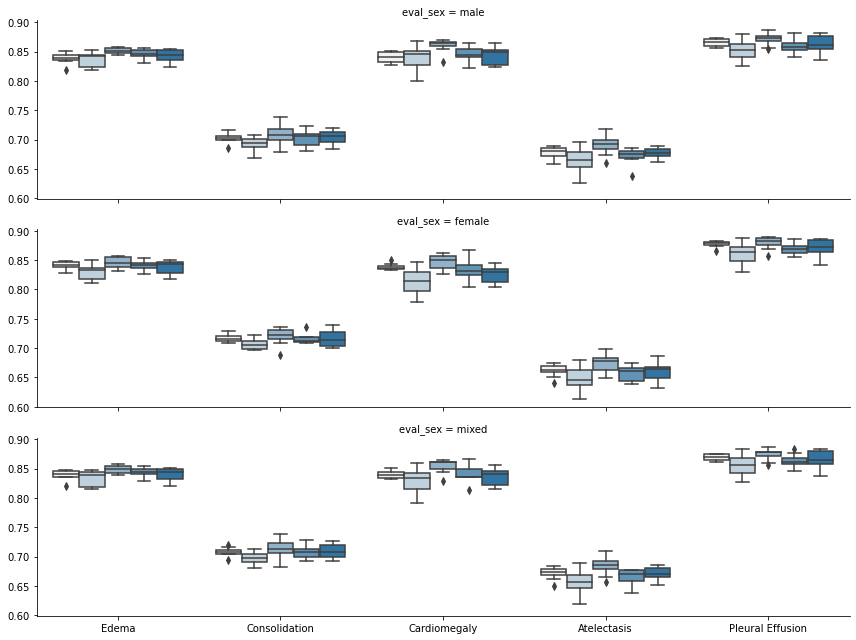

In [18]:
#fig, ax = plt.subplots(figsize=(20,15))
g = sns.FacetGrid(results, row="eval_sex", height=3, aspect=4)
g.map_dataframe(sns.boxplot, x='pathology', y ='AUC', hue='train_population')

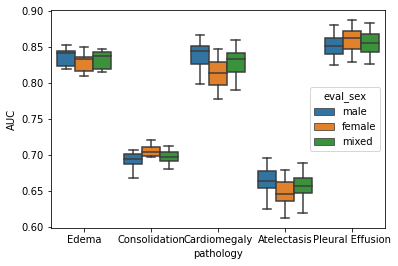

In [19]:
ax = sns.boxplot(data=results[results.train_population=='male'], 
                 x = 'pathology', y = 'AUC', hue='eval_sex')
#plt.ylim(0.8,0.9)

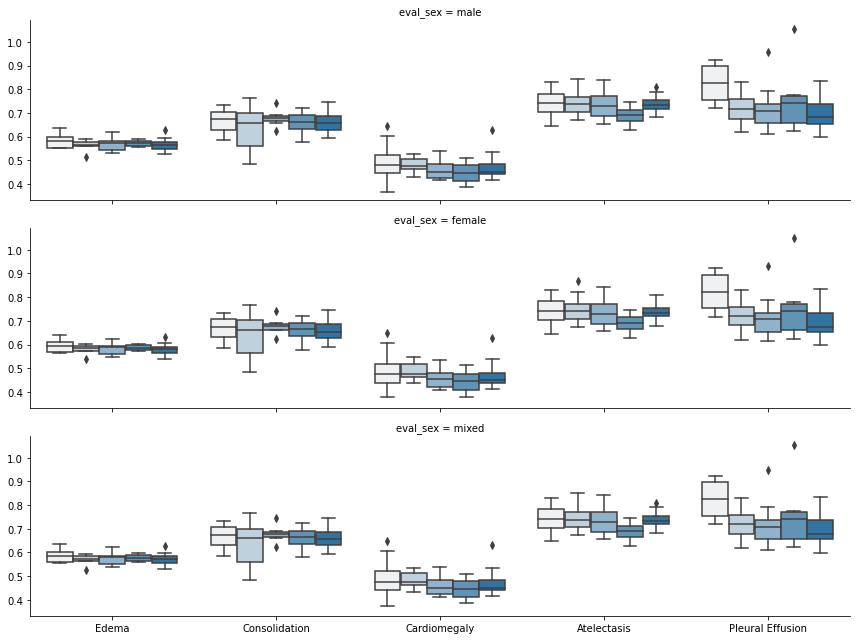

In [20]:
#fig, ax = plt.subplots(figsize=(20,15))
g = sns.FacetGrid(results, row="eval_sex", height=3, aspect=4)
g.map_dataframe(sns.boxplot, x='pathology', y ='log loss', hue='train_population')

In [21]:
results[results.pathology == 'Edema'] #.pivot(index='train_population', columns='eval_sex')

,iter,train_population,pathology,AUC,log loss,eval_sex
0,1,female,Edema,0.844662,0.578344,male
1,1,female,Edema,0.845975,0.591570,female
2,1,female,Edema,0.845406,0.583640,mixed
3,1,male,Edema,0.841479,0.584468,male
4,1,male,Edema,0.834754,0.598776,female
...,...,...,...,...,...,...
115,8,old_selection,Edema,0.845960,0.577441,female
116,8,old_selection,Edema,0.851319,0.566619,mixed
117,8,young_selection,Edema,0.839047,0.565203,male
118,8,young_selection,Edema,0.830802,0.587511,female
